# Large Notebook 3: Reinfocement Learning
## Ex. 3: Control problem MountainCar-v0

In the exercise class we will cover the control problem of a car at the bottom of a valley which should pick-up enough momentum to get over the hill. We will use the environment from the OpenAI Gym, which allows you to play and visualize the 'game'. Use RL to train a policy that gets the car over the hill in the least amount of time. 

**Before you can start this exercise you have to install the package OpenAI Gym. Start your anaconda environment with python3 and install:**

* pip install gymnasium[classic-control]


In [1]:
# UNCOMMENT IF GYMNASIUM FAILS TO IMPORT
%pip install gymnasium[classic-control]

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\Konstantinos\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


If you have properly installed the openAI gym you should be able to import it. We will now run a DEMO to see if everything is working. The code already is able to simulate the MountainCar problem for the case that it actions are **random**. To be able to view the rendered video of the poor and helpless car, desperately trying to drive up the hill, you should run the code on your own computer.
For more info on this particular environment see e.g. the website: https://gymnasium.farama.org/environments/classic_control/mountain_car/



In [2]:
def demo():
    """run the MountainCar environment with random actions"""
    
    env = gym.make('MountainCar-v0', render_mode='human')  #  create an instance of the environment

    state = env.reset()  # reset the current game

    for _ in range(200):  # play 200 random actions
        env.render()  # render the current game state to screen
        a = env.action_space.sample()  # get a random action
        state, reward, terminated, truncated, info = env.step(a) # take the action and return the outcome
        
    env.close()
    
# run the demo
demo() 

## Building your RL player, ie. training your policy.
We have to start by creating the game environment and checking some properties of the state and action space:

In [3]:
env = gym.make('MountainCar-v0')  # no rendering!

# get usefull information about the environment:
state = env.reset()
print('start state:', state)
print('Number of sctions in the action space:', env.action_space.n)
print('Lowest state in the state space:', env.observation_space.low)
print('Hightest state in the state space:', env.observation_space.high)

#perform one step of the game for action a=1
a=1
state, reward, terminated, truncated, info = env.step(a)
print('After the step with (a=1):',state, reward, terminated, truncated, info )


start state: (array([-0.40802196,  0.        ], dtype=float32), {})
Number of sctions in the action space: 3
Lowest state in the state space: [-1.2  -0.07]
Hightest state in the state space: [0.6  0.07]
After the step with (a=1): [-0.40887153 -0.00084956] -1.0 False False {}


We see that the car starts out in state with two floats [-0.525, 0] (as it initializes random these numbers will differ each time you reset). You can perform any of 3 actions (a = 0 or 1 or 2). We don't know what the numbers in the state mean, they could be the $x$, $y$ coordinates of the car or the velocity and height, but **we also don't have to know!** We will let the RL algortithm learn how to drive the car regardless of the exact meaning of the state.

You should now code a function `s2q(s)` that links state `s` to a location in the Q-matrix. This can quickly be done by discretizing the state space into bins and determine the bin number corresponding to a certain value. The function should return a tuple (or list) `loc` that holds the two bin numbers.

In [4]:
def s2q(s, nbins1 = 20, nbins2 = 20):
    # convert continous state values to discrete location indices inside the Q matrix
    
    low = env.observation_space.low
    high = env.observation_space.high
    bins = (nbins1,nbins2)
    
    bin_sizes = [(high[i] - low[i]) / bins[i] for i in range(len(s))]
    
    # Compute bin index for each dimension
    loc = [np.int_((s[i] - low[i]) / bin_sizes[i]) for i in range(len(s))]
    
    # Clip values to stay within valid range
    loc = [np.clip(loc[i], 0, bins[i] - 1) for i in range(len(s))]

    return loc

s2q(state)

[np.int64(8), np.int64(9)]

The next function `qlearn()` should train your Q-matrix by playing `num_games` games according to an 'epsilon-greedy' strategy (Google it!) and update the Q-matrix accoding to the following Bellmann equation:

$$ \mathbf{Q}^{\rm new}[s_t,a_t]=(1-\alpha)\mathbf{Q}[s_t,a_t]+\alpha\left(R_t+\gamma\, \text{max}_a  \mathbf{Q}[s_{t+1},a]\right). $$

Here, $\alpha$ is the learning rate and $\gamma$ is the discount factor and are bounded by $\alpha,\gamma\in[0,1]$. These parameters have to be set with care, as they influence the speed of convergence of the Q-matrix. The discount factor lets you weigh the importance of future over immediate rewards. This is done by mixing-in the term $\text{max}_a  \mathbf{Q}[s_{t+1},a]$, which gives the maximum Q value in the future state.

In [5]:
def qLearn(Q, α, γ, ϵ, ϵ_min, num_games, max_it=1000, nbins1 = 20, nbins2 = 20):
    """ 
    learns the Q table by interacting with the environment and applying the Bellman equation 
    Q: q-table (n-dimensional ndarray)
    α: learning rate
    γ: discount factor
    ϵ: probability of taking a random action in the epsilon-greedy policy
    ϵ_min: minimum value ϵ can take when applying a reduction algortihm to ϵ
    """

    state = env.reset()  # reset the current game
    wins = 0
    avg = 0
    for game in range(num_games):
        state = env.reset()[0]
        state = s2q(state, nbins1=nbins1, nbins2=nbins2)
        won = False
        total = 0
        it = 0
        
        while not won and it<max_it:
            
            if np.random.rand() < ϵ:
                action = env.action_space.sample()  # Random action
            else:
                action = np.argmax(Q[state[0]][state[1]])  # Best action from Q-table
            next_state, reward, won,_,_ = env.step(action)
            
            next_state = s2q(next_state, nbins1=nbins1, nbins2=nbins2)
            Q[state[0]][state[1]][action] = (1 - α) * Q[state[0]][state[1]][action] + α * (reward + γ * np.max(Q[next_state[0]][next_state[1]]))
            
            total += reward
            
            state = next_state
            
            it+=1
        ϵ = max(ϵ_min, ϵ * 0.9)
        
        if won:
            wins += 1
        avg += total
        
    print(f'Training ended. Number of wins: {wins}')
    return wins, avg/num_games

Finally you put everything together. It is almost completly finished for you. What values for the hyperparameters do you choose? 

In [26]:
# initialize the Q matrix as a numpy array with zeros
Q = np.zeros(shape=(20,20,3))

env = gym.make('MountainCar-v0')
env.reset()

# set the hyperparameters
α = 0.5  # learning rate [0,1]
γ = 0.5  # discount rate [0,1]
ϵ = 1  # epsilon greedy strategy [0,1]
ϵ_min = 0  # minimum value of epsilon [0,1]
num_games = 100 # number of training games

# train the agent and store results
wins, avg = qLearn(Q, α, γ, ϵ, ϵ_min, num_games, max_it=1000)
print(f"avg: {avg}")
np.save('qrun1.npy', Q)


Training ended. Number of wins: 79
avg: -565.75


Once a Q-matrix has been trained we can use it as a policy and play a game. Write code that performs actions according to the input Q-matrix to play a single episode.

In [27]:
# replay the game using the trained Q matrix
Q = np.load('qrun1.npy')

# create and reset the environment with render mode on
env = gym.make('MountainCar-v0', render_mode='human')
state = env.reset()[0]  
    
# play a single episode with max. 1000 actions
for _ in range(1000):           
    env.render()                
    loc = s2q(state)
    a = np.argmax(Q[loc[0]][loc[1]]) 
    state, reward, terminated, truncated, info = env.step(a) 
        
    if terminated: 
        print('Qplay Output:', reward, terminated, truncated, info)
        break

env.close()

Qplay Output: -1.0 True True {}


# Experiments
Set up a couple fo experiments to figure out the following things:
* How do $\alpha$ and $\gamma$ effect your learning perfomance?
* Are both elements of the state vector equally important and can we reduce the dimensions of the Q-matrix of one (or both) of them?

## Experiment 1: Optimizing $\alpha$ and $\gamma$

For this experiment a grid of 5 alphas and gammas ranging between 0 and 1 is created. The model is trained 3 times for each of the 25 parameter combinations. The average of the 3 training sessions is plotted in a mesh to see the performance

In [28]:
α_list = np.linspace(0, 1, 5)
γ_list = np.linspace(0, 1, 5)

env = gym.make('MountainCar-v0')
env.reset()

α_grid, γ_grid = np.meshgrid(α_list, γ_list)
wins_grid = np.zeros_like(α_grid)

# Run simulations and store results
for i in range(len(α_list)):
    for j in range(len(γ_list)):
        avg = 0
        for _ in range(3):
            Q = np.zeros(shape=(20, 20, 3))
            wins, _ = qLearn(Q, α_grid[i, j], γ_grid[i, j], ϵ, ϵ_min, num_games)
            avg += wins
        wins_grid[j, i] = avg/3
        print(f'α:{ α_grid[i, j]}, γ:{γ_grid[i, j]}, avg wins:{avg/3}')

Training ended. Number of wins: 0
Training ended. Number of wins: 0
Training ended. Number of wins: 0
α:0.0, γ:0.0, avg wins:0.0
Training ended. Number of wins: 0
Training ended. Number of wins: 0
Training ended. Number of wins: 0
α:0.25, γ:0.0, avg wins:0.0
Training ended. Number of wins: 0
Training ended. Number of wins: 0
Training ended. Number of wins: 0
α:0.5, γ:0.0, avg wins:0.0
Training ended. Number of wins: 0
Training ended. Number of wins: 0
Training ended. Number of wins: 0
α:0.75, γ:0.0, avg wins:0.0
Training ended. Number of wins: 0
Training ended. Number of wins: 0
Training ended. Number of wins: 0
α:1.0, γ:0.0, avg wins:0.0
Training ended. Number of wins: 0
Training ended. Number of wins: 0
Training ended. Number of wins: 0
α:0.0, γ:0.25, avg wins:0.0
Training ended. Number of wins: 58
Training ended. Number of wins: 61
Training ended. Number of wins: 60
α:0.25, γ:0.25, avg wins:59.666666666666664
Training ended. Number of wins: 73
Training ended. Number of wins: 55
Trai

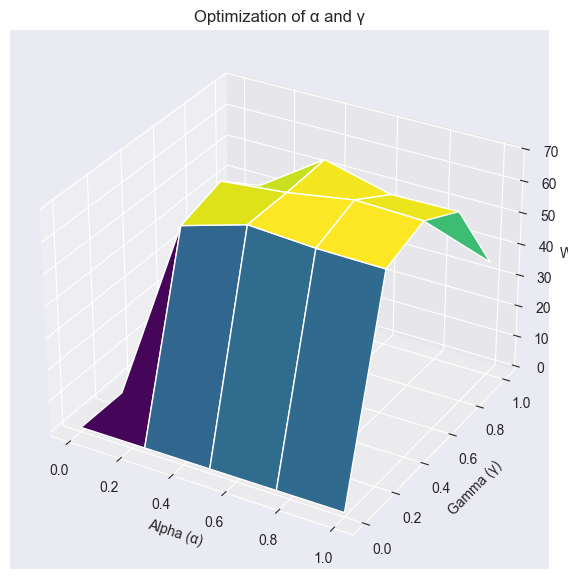

In [29]:
# Plot the results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(α_grid, γ_grid, wins_grid, cmap='viridis')

# Labels
ax.set_xlabel('Alpha (α)')
ax.set_ylabel('Gamma (γ)')
ax.set_zlabel('Wins')
ax.set_title('Optimization of α and γ')

plt.show()

As expected, when alfa=0 the number of wins is 0, as  according to the Bellmann equation, Q stays the same as in the previous iteration. When gamma=0, the equation doesn't consider the predicted highest Q for the next iteration, which also results in an average of 0 wins. 
The peak value of wins (76.3) can be seen for the parameter combination of alfa=0.5, gamma=0.75.

## Experiment 2: Reducing the dimensionality of the state space

 In this experiment we will explore the importance of the states. This will be done by disregarding one of the states and training the algorithm. This will be done for each of the states 5 times and then the average results will be compared. 

As training parameters we use the results obtained from the previous experiment

In [14]:
nbins1 = 1
nbins2 = 20

# set the hyperparameters
α = 0.5  # learning rate [0,1]
γ = 0.75  # discount rate [0,1]
ϵ = 1  # epsilon greedy strategy [0,1]
ϵ_min = 0  # minimum value of epsilon [0,1]
num_games = 100 # number of training games

env = gym.make('MountainCar-v0')
env.reset()

# train the agent and store results
avg_wins = 0
avg_reward = 0
for _ in range(5):
    Q = np.zeros(shape=(nbins1,nbins2,3))
    wins, avg = qLearn(Q, α, γ, ϵ, ϵ_min, num_games, max_it=1000, nbins1=nbins1, nbins2=nbins2)
    avg_wins += wins
    avg_reward += avg
print(f"avg reward when ignoring state 1: {avg_reward/5}")
print(f"avg wins when ignoring state 1: {avg_wins/5}")
np.save('qrunIgnoringState1.npy', Q)

Training ended. Number of wins: 58
Training ended. Number of wins: 51
Training ended. Number of wins: 83
Training ended. Number of wins: 72
Training ended. Number of wins: 63
avg reward when ignoring state 1: -587.3580000000001
avg wins when ignoring state 1: 65.4


In [11]:
nbins1 = 20
nbins2 = 1

# set the hyperparameters
α = 0.5  # learning rate [0,1]
γ = 0.75  # discount rate [0,1]
ϵ = 1  # epsilon greedy strategy [0,1]
ϵ_min = 0  # minimum value of epsilon [0,1]
num_games = 100 # number of training games

env = gym.make('MountainCar-v0')
env.reset()

# train the agent and store results
avg_wins = 0
avg_reward = 0
for _ in range(5):
    Q = np.zeros(shape=(nbins1,nbins2,3))
    wins, avg = qLearn(Q, α, γ, ϵ, ϵ_min, num_games, max_it=1000, nbins1=nbins1, nbins2=nbins2)
    avg_wins += wins
    avg_reward += avg
print(f"avg reward when ignoring state 2: {avg_reward/5}")
print(f"avg wins when ignoring state 2: {avg_wins/5}")
np.save('qrunIgnoringState2.npy', Q)

Training ended. Number of wins: 0
Training ended. Number of wins: 0
Training ended. Number of wins: 0
Training ended. Number of wins: 0
Training ended. Number of wins: 0
avg reward when ignoring state 2: -1000.0
avg wins when ignoring state 2: 0.0


As can be seen the first state, the position, of the car can be ignored with minimal degradation in performance. However, when ignoring the second state, the car's velocity, the car never reaches the goal. This shows that velocity is critical while position is quite insignificant for the training result. There is a possibility that changing the training parameters for the model which ignores position could lead to a winning model but there is no guarantee.

Below you can watch the two replays:

In [15]:
# replay the game using the trained Q matrix which ignores the position of the car
Q = np.load('qrunIgnoringState1.npy')

# create and reset the environment with render mode on
env = gym.make('MountainCar-v0', render_mode='human')
state = env.reset()[0]  
    
# play a single episode with max. 1000 actions
for _ in range(1000):           
    env.render()                
    loc = s2q(state, nbins1=1, nbins2=20)
    a = np.argmax(Q[loc[0]][loc[1]]) 
    state, reward, terminated, truncated, info = env.step(a) 
        
    if terminated: 
        print('Qplay Output:', reward, terminated, truncated, info)
        break

env.close()

Qplay Output: -1.0 True True {}


In [17]:
# replay the game using the trained Q matrix which ignores the velocity of the car
Q = np.load('qrunIgnoringState2.npy')

# create and reset the environment with render mode on
env = gym.make('MountainCar-v0', render_mode='human')
state = env.reset()[0]  
    
# play a single episode with max. 1000 actions
for _ in range(1000):           
    env.render()                
    loc = s2q(state, nbins1=20, nbins2=1)
    a = np.argmax(Q[loc[0]][loc[1]]) 
    state, reward, terminated, truncated, info = env.step(a) 
        
    if terminated: 
        print('Qplay Output:', reward, terminated, truncated, info)
        break

env.close()